In [7]:
# Import modules
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import os


def work_space(path):
    while True:
        if os.path.split(path)[1] != "Phys117":
            path = os.path.split(path)[0]
        else:
            return path.replace("\\", "/")

work_dir = work_space(os.getcwd())
data_path = work_dir + "/Markus/Hub/EventData/"
save_path = work_dir + "/Markus/Hub/VariableData/"

folders = os.listdir(data_path)
data_files = [data_path + data_file for data_file in folders]
stuffs = ["electron", "jet", "MET", "muon", "photon", "tau"]
data_variables = ["HT", "met", "phi_diff", "ptmax", "stuff_amount"]
file_amounts = [2, 18, 3]


def unpacker(folder_data, new_folder_data):
    for nested_list in folder_data:
        if type(nested_list) == list:
            unpacker(nested_list, new_folder_data)
        else:
            new_folder_data.append(nested_list)
    folder_data = new_folder_data
    return folder_data


def input_data(event):
    name_index = 0
    pt_index = name_index + 3
    phi_index = name_index + 2

    met_particle = [particle for particle in event if particle[name_index] == "MET"][0]
    met = met_particle[pt_index]

    ht = np.sum([particle[pt_index] for particle in event])

    stuff_amount = len(event)

    ptmax_particle = sorted(event, key = lambda x: x[pt_index])[-1]
    ptmax = ptmax_particle[pt_index]
    
    phi_diff = (ptmax_particle[phi_index] - met_particle[phi_index]) % np.pi
    input_list = [ht, met, phi_diff, ptmax, stuff_amount]
    
    return input_list


def dataframe_calc(dataframe):
    import ast
    dataframe_dict = {}
    events = [row for row in dataframe.itertuples(index = False)]
    for event_index, event in enumerate(events):
        event = [tuple(ast.literal_eval(element)for element in particle.strip("()").split(", ")) for particle in event if "nan" not in particle]
        dataframe_dict[event_index] = input_data(event)
    input_variables = data_variables
    data_df = list(dataframe_dict.values())
    dataframe = pd.DataFrame(data_df, columns = input_variables)
    return dataframe


def data_binner(data, binsize):
    data = unpacker(data, [])

    if len(data) == 0:
        x = [bin * binsize for bin in range(200)]
        y = [0 for bin in range(200)]
        return x, y

    max_value = np.max(data)
    bins = int(np.round(max_value / binsize))
    bins = np.arange(0, bins)
    data = np.array(data)
    x, y = [], []

    for bin in range(len(bins)):
        temp = data
        temp = temp[temp <= (bin + 1/2)*binsize]
        temp = temp[(bin - 1/2)*binsize < temp]
        if len(temp) != 0:
            y.append(len(temp))
            x.append(bin*binsize)

    y = y/np.sum(y)

    return x, y
 

def plot_filter(interval_data, filter_strength):
    interval_data = sorted(interval_data)
    cutoff = round((len(interval_data) * filter_strength))
    interval_data = interval_data[:cutoff]
    x_min = np.min(interval_data)
    x_max = np.max(interval_data)
    extra = (x_max - x_min) / 10
    return [x_min - extra, x_max + extra]


def plot_data(foldered_dataframes, foldered_filenames):
    input_dataframes = foldered_dataframes
    output_dataframe = [[dataframe_calc(dataframe) for dataframe in dataframes] for dataframes in input_dataframes]
    output_filenames = foldered_filenames

    return output_dataframe, output_filenames


def sampler(output_dataframe, output_filenames, file_amounts, combine_data):
    from random import sample

    output_dataframe = [[(dataframe, filename) for dataframe, filename in zip(dataframes, filenames)] for dataframes, filenames in zip(output_dataframe, output_filenames)]
    samples = [sample(dataframes, file_amount) for dataframes, file_amount in zip(output_dataframe, file_amounts)]

    if combine_data:
        output_dataframe = [pd.concat([sample[0] for sample in dataframes]) for dataframes in samples]
        labels = folders
    else:
        output_dataframe = [sample[0] for dataframes in samples for sample in dataframes]
        labels = [sample[1] for dataframes in samples for sample in dataframes]
    
    output_dataframe = unpacker(output_dataframe, [])
    lables = unpacker(labels, [])
        

    return output_dataframe, labels


def plotter(data_variables, output_dataframe, output_filenames, filter_strengths, binsizes):

    for variable_index, variable in enumerate(data_variables):
        fig = plt.figure()
        style = "seaborn-v0_8-darkgrid"
        plt.style.use(style)
        title = variable + " Distribution"
        fig.suptitle(title)
        plt.xlabel(variable)
        plt.ylabel("frequency")

        binsize = binsizes[variable_index] if type(binsizes) == list else binsizes
        filter_strength = filter_strengths[variable_index] if type(filter_strengths) == list else filter_strengths
        interval = np.concatenate([dataframe[variable] for dataframe in output_dataframe])
        plt.xlim(plot_filter(interval, filter_strength))

        for dataframe, label in zip(output_dataframe, output_filenames):
            raw_data = dataframe[variable]
            bins, counts = data_binner(raw_data, binsize)
            plt.plot(bins, counts, label = label)
        
        plt.legend(prop = {'size': 8})
        plt.show()

In [8]:
foldered_dataframes = []
for folder in folders:
    dataframes = []
    data_files = [data_path + folder + "/" + data_file for data_file in os.listdir(data_path + folder)]
    for data_file in data_files:
        data = pd.read_csv(data_file)
        data = data.drop(["Unnamed: 0", "datasets"], axis = 1)
        dataframes.append(data)
    foldered_dataframes.append(dataframes)


foldered_filenames = []
for folder in folders:
    filenames = os.listdir(data_path + folder)
    foldered_filenames.append(filenames)

In [9]:
output_dataframe, output_filenames = plot_data(foldered_dataframes, foldered_filenames)

In [10]:
for folder_dataframes, folder_filenames, folder in zip(output_dataframe, output_filenames, folders):
    for dataframe, filename in zip(folder_dataframes, folder_filenames):
        file_path = save_path + folder + "/" + filename
        dataframe.to_csv(file_path)

In [11]:
data_sample, labels = sampler(output_dataframe, output_filenames, file_amounts = [0, 18, 3], combine_data = False)

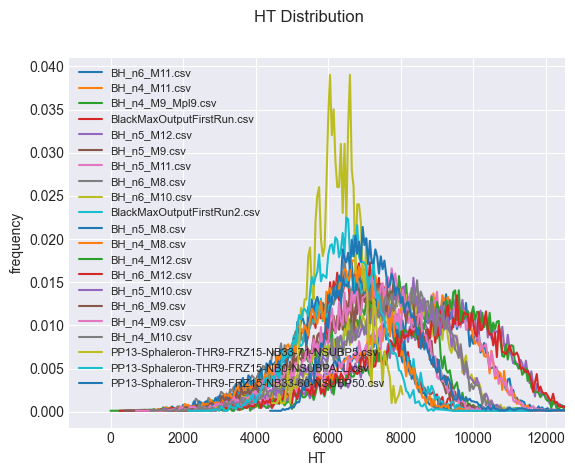

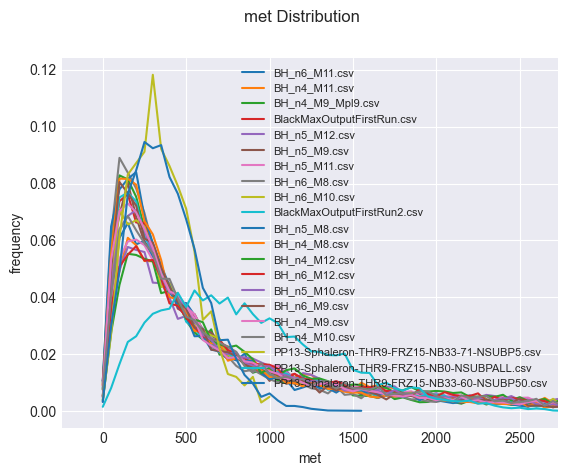

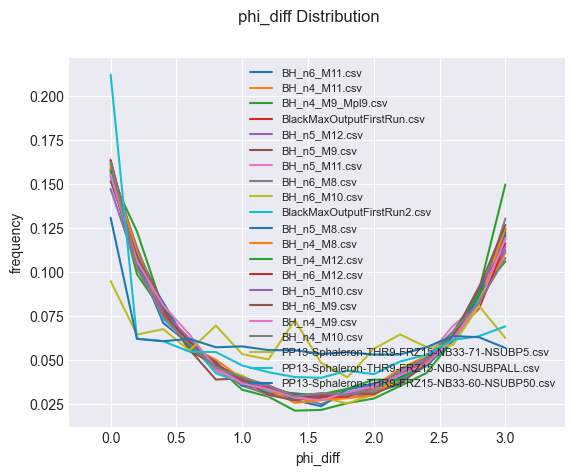

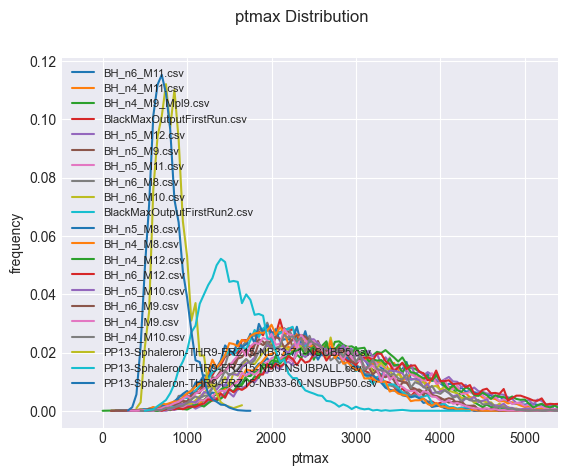

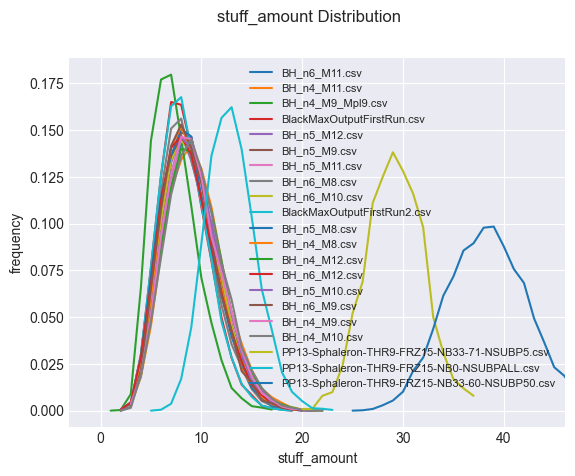

In [16]:
plotter(data_variables, data_sample, labels, filter_strengths = [0.99, 0.95, 1, 0.99, 0.99], binsizes = [50, 50, 0.2, 50, 0.5])